In [32]:
import glob
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.wcs import WCS
from astropy.visualization import simple_norm
from astropy.stats import sigma_clipped_stats
import ccdproc
import photutils

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.figsize'] = (18, 9)

In [4]:
darks = glob.glob('~data/darks/83F010774/T-00C/300s/*.fits')
darks_combiner = ccdproc.Combiner([ccdproc.CCDData.read(fname, unit='adu') for fname in darks])
master_dark = darks_combiner.median_combine()
del(darks_combiner)
master_dark.header['EXPTIME'] = 300
master_dark.write('master_dark_300s.fits', overwrite=True)

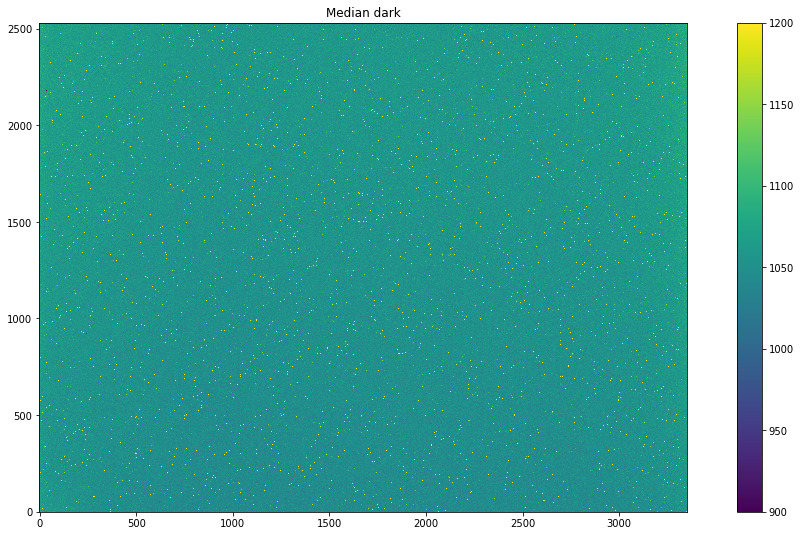

In [5]:
plt.imshow(master_dark, vmin=900, vmax=1200, origin='lower')
plt.title('Median dark')
plt.colorbar()

In [6]:
flats = glob.glob('~/data/flats/83F010774/*/flat_*.fits', recursive=True)
flats.sort()

flat_darks = glob.glob('~/data/flats/83F010774/*/dark_*.fits', recursive=True)
flat_darks.sort()

flats_ds = []
for flat_name, flat_dark_name in zip(flats, flat_darks):
    flat = ccdproc.CCDData.read(flat_name, unit='adu')
    median = np.median(flat)
    if median > 20000 or median < 5000:
        continue
    dark = ccdproc.CCDData.read(flat_dark_name, unit='adu')
    flat_ds = ccdproc.subtract_dark(flat, dark, exposure_time='EXPTIME', exposure_unit=u.second)
    flats_ds.append(flat_ds)

flat_combiner = ccdproc.Combiner(flats_ds)
del(flats_ds)
flat_combiner.scaling = lambda x: 1 / np.ma.median(x)
master_flat = flat_combiner.median_combine()
del(flat_combiner)
master_flat.mask[master_flat<0.75*u.adu] = True
master_flat.write('master_median.fits', overwrite=True)

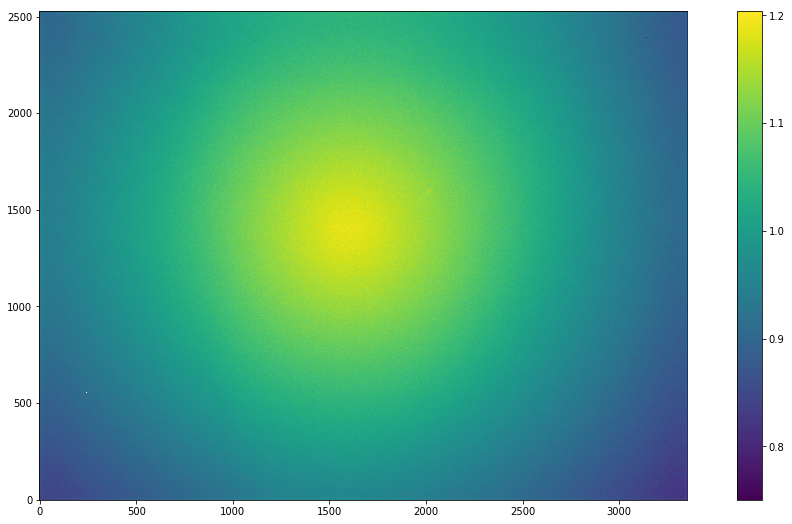

In [7]:
plt.imshow(master_flat, origin='lower')
plt.colorbar()

In [8]:
data_names = glob.glob('~/data/ngc6744/83F010774/*/*.fits')
data_names.sort()

names = []
for data_name in data_names:
    name = os.path.basename(data_name)
    data = ccdproc.CCDData.read(data_name, unit='adu')
    data = ccdproc.subtract_dark(data, master_dark, exposure_time='EXPTIME', exposure_unit=u.second)
    data = ccdproc.flat_correct(data, master_flat)
    data.write(name, overwrite=True)
    print("Processed {}".format(name))
    names.append(name)
    
len(names)

Processed 20180801T085727.fits
Processed 20180801T090307.fits
Processed 20180801T090848.fits
Processed 20180801T091428.fits
Processed 20180801T092012.fits
Processed 20180801T092554.fits
Processed 20180801T093139.fits
Processed 20180801T093724.fits
Processed 20180801T094311.fits
Processed 20180801T095053.fits
Processed 20180801T095624.fits
Processed 20180801T100211.fits
Processed 20180801T100803.fits
Processed 20180801T101347.fits
Processed 20180801T101935.fits
Processed 20180801T102522.fits
Processed 20180801T103113.fits
Processed 20180801T103642.fits
Processed 20180801T104438.fits
Processed 20180801T105025.fits
Processed 20180801T105607.fits
Processed 20180801T110142.fits
Processed 20180801T110722.fits
Processed 20180801T111304.fits
Processed 20180801T111848.fits
Processed 20180801T112428.fits
Processed 20180801T113005.fits
Processed 20180801T113755.fits
Processed 20180801T114338.fits
Processed 20180801T114918.fits
Processed 20180801T115502.fits
Processed 20180801T120038.fits
Processe

63

In [9]:
starfinder = photutils.detection.DAOStarFinder(threshold=3000, fwhm=2)
good_names = []

for name in names:
    data = ccdproc.CCDData.read(name)
    mean, median, std = sigma_clipped_stats(np.ma.array(data.data, mask=data.mask), sigma=3.0, iters=5)
    stars = starfinder.find_stars(data - median)
    sharpness = np.nanmedian(stars['sharpness'].quantity)
    roundness = np.nanmedian(stars['roundness2'].quantity)
    if abs(roundness) < 0.2 and median < 1600 and sharpness > 0.65:
        print(name, median, len(stars), sharpness, roundness, 'O')
        good_names.append(name)
    else:
        print(name, median, len(stars), sharpness, roundness, 'X')

/home2/ajh/anaconda3/envs/POCS/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:165: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/home2/ajh/anaconda3/envs/POCS/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:166: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value
/home2/ajh/anaconda3/envs/POCS/lib/python3.6/site-packages/photutils/detection/findstars.py:399: RuntimeWarning: invalid value encountered in greater
  object_labels, nobjects = ndimage.label(convolved_data > threshold,
/home2/ajh/anaconda3/envs/POCS/lib/python3.6/site-packages/photutils/detection/core.py:241: RuntimeWarning: invalid value encountered in greater
  peak_goodmask = np.logical_and(peak_goodmask, (data > threshold))


20180801T085727.fits 422.3719613910896 2942 0.6708776866834192 -0.8684422611706194 X
20180801T090307.fits 418.60114292204184 2528 0.6588835935158754 -0.869593463921692 X
20180801T090848.fits 413.8292135832005 2747 0.6972047783337779 -0.8736037262819392 X
20180801T091428.fits 413.07032335820463 1339 0.6897929180227687 -0.8743439689346894 X
20180801T092012.fits 409.51496573440727 1265 0.6591196661091794 -0.8457928214370327 X
20180801T092554.fits 410.48120386337894 6020 0.8532285206257872 0.13379606449088535 O
20180801T093139.fits 412.76638528934114 1335 0.6591287501950264 -0.8208446789084595 X
20180801T093724.fits 408.62635662812704 5261 0.8222911539560548 0.06567763445653665 O
20180801T094311.fits 406.96851839647417 4895 0.8101344336170743 -0.0134179266948584 O
20180801T095053.fits 401.12054259354943 4586 0.827360989942678 0.2408470754339434 X
20180801T095624.fits 398.88176393945935 4809 0.8497304147119003 0.09172642332776061 O
20180801T100211.fits 393.323644295453 4513 0.84322218295310

/home2/ajh/anaconda3/envs/POCS/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/home2/ajh/anaconda3/envs/POCS/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


20180801T104438.fits 384.41783676371546 3236 0.8150938563072241 0.1254379738874833 O
20180801T105025.fits 381.247256814328 3234 0.8398434720100828 0.11180271791296072 O
20180801T105607.fits 384.7740970597961 3042 0.8415354898648997 0.1376070344507037 O
20180801T110142.fits 389.0872409943973 2867 0.8344696751742767 0.14043412900475313 O
20180801T110722.fits 415.71920067286203 2699 0.8194540322601405 0.13750389172181732 O
20180801T111304.fits 475.2123659561297 2557 0.8388758357987909 0.14264996051341206 O
20180801T111848.fits 607.7851300155486 2478 0.82871404928175 0.13201703508636484 O
20180801T112428.fits 804.0831104105357 2354 0.8164170136340985 0.10621437491447366 O
20180801T113005.fits 1044.6290775890923 2244 0.8106285495608845 0.08320767549122764 O
20180801T113755.fits 1396.0381662913264 2161 0.8208406296026084 0.1429640399146762 O
20180801T114338.fits 1636.819394537557 2019 0.8128104058367596 0.1747347298696007 X
20180801T114918.fits 1846.5847100510518 1925 0.8099458170803584 0.13

/home2/ajh/anaconda3/envs/POCS/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


20180802T110515.fits 378.4344907305682 0 nan nan X
20180802T111103.fits 376.5056207789496 0 nan nan X
20180802T111655.fits 373.5269601883464 0 nan nan X
20180802T112244.fits 366.26677000130405 0 nan nan X
20180802T112829.fits 363.584082891473 0 nan nan X
20180802T113415.fits 338.79050497782765 0 nan nan X
20180802T114004.fits 317.5930653189483 0 nan nan X
20180802T114547.fits 187.14644410835155 0 nan nan X
20180802T115407.fits 139.74260023033096 0 nan nan X
20180802T115955.fits 85.50666029346108 0 nan nan X
20180802T120549.fits 54.56703485403616 0 nan nan X
20180802T121159.fits 64.21589877653187 0 nan nan X
20180802T121915.fits 538.8456490921186 0 nan nan X


In [21]:
len(good_names)

28

In [27]:
straightened_pixel_scale = (2 * u.arcsecond).to(u.degree)
straightened_wcs = WCS(naxis=2)
straightened_wcs.wcs.ctype = ['RA---TAN', 'DEC--TAN']
straightened_wcs.wcs.cdelt = (-straightened_pixel_scale.value, -straightened_pixel_scale.value)
straightened_wcs.wcs.crval = 287.4409512, -63.85906095
straightened_wcs.wcs.crpix = 1000.5, 1000.5

In [28]:
resampled = []

for name in good_names:
    data = ccdproc.CCDData.read(name)
    straightened_data = ccdproc.wcs_project(data, straightened_wcs, target_shape=(2000,2000))
    mean, median, std = sigma_clipped_stats(np.ma.array(straightened_data.data,
                                                        mask=straightened_data.mask), sigma=3.0, iters=5)
    straightened_data = straightened_data.subtract(median * u.adu)
    resampled.append(straightened_data)
    
resampled_combiner = ccdproc.Combiner(resampled)
del(resampled)
median_galaxy = resampled_combiner.median_combine()
del(resampled_combiner)
median_galaxy.wcs = straightened_wcs
median_galaxy.write('ngc6744.fits', overwrite=True)

/home2/ajh/anaconda3/envs/POCS/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:165: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/home2/ajh/anaconda3/envs/POCS/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:166: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value
/home2/ajh/anaconda3/envs/POCS/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 79 results
  r = func(a, **kwargs)


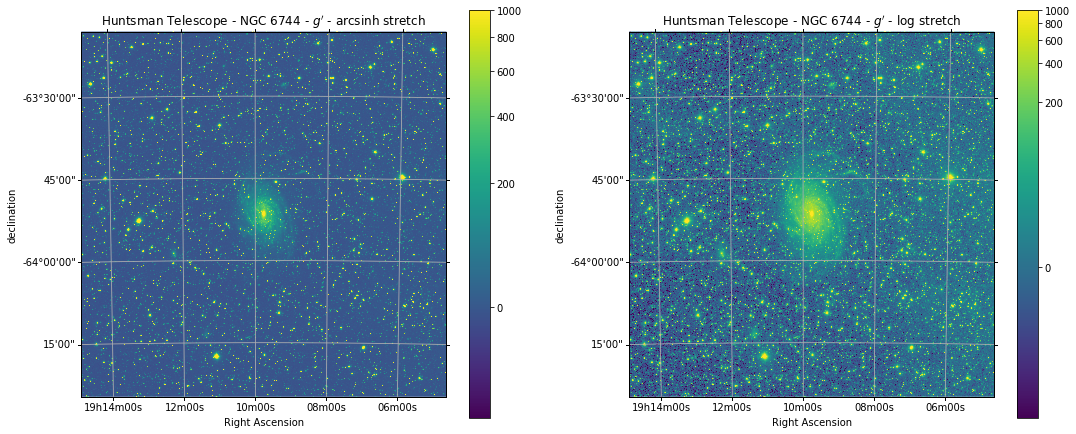

In [57]:
fig = plt.figure(figsize=(18,7.5))

asinh_norm = simple_norm(data, stretch='asinh', min_cut=-100, max_cut=1000, asinh_a=0.1)
ax1 = plt.subplot(1, 2, 1, projection=straightened_wcs)
im_asinh = ax1.imshow(median_galaxy, cmap='viridis', norm=asinh_norm)
ax1.coords[0].set_axislabel('Right Ascension')
ax1.coords[0].set_major_formatter('hh:mm:ss')
ax1.coords[1].set_axislabel('declination')
ax1.coords[1].set_major_formatter('dd:mm:ss')
ax1.grid()
ax1.set_title("Huntsman Telescope - NGC 6744 - $g'$ - arcsinh stretch")
fig.colorbar(im_asinh, ax=ax1)

log_norm = simple_norm(data, stretch='log', min_cut=-12, max_cut=1000)
ax2 = plt.subplot(1, 2, 2, projection=straightened_wcs)
im_log = ax2.imshow(median_galaxy, cmap='viridis', norm=log_norm)
ax2.coords[0].set_axislabel('Right Ascension')
ax2.coords[0].set_major_formatter('hh:mm:ss')
ax2.coords[1].set_axislabel('declination')
ax2.coords[1].set_major_formatter('dd:mm:ss')
ax2.grid()
ax2.set_title("Huntsman Telescope - NGC 6744 - $g'$ - log stretch")
fig.colorbar(im_log, ax=ax2)

fig.savefig('ngc6744_science.png', dpi=200)